In [1]:
import os, glob
import numpy as np
import pandas as pd
from scipy import stats
w_list= glob.glob("../result/merge_weather/*.csv")
pd.set_option('display.max_rows', 20)

# 玫瑰 : 台中，彰化，雲林，嘉義，南投，高雄，屏東
# 洋桔梗 : 南投，彰化，雲林，嘉義，台南
# 大菊 : 彰化，雲林，南投
# 火鶴花 : 台中，嘉義，南投，台南，高雄，屏東
# 香水百合 :台中，南投，嘉義

# flowers = []
# for fn in get_f_list:
#     flowers.append(fn.split("\\")[-1].split("_")[0])

# flower = flowers[0]
# fn_list = glob.glob("../result/merge_flower_price/*" + flower + "*.csv")
w_list

['../result/merge_weather\\467480_嘉義.csv',
 '../result/merge_weather\\C0F9L0_后里.csv',
 '../result/merge_weather\\C0G650_員林.csv',
 '../result/merge_weather\\C0H960_草屯.csv',
 '../result/merge_weather\\C0K490_古坑.csv',
 '../result/merge_weather\\C0R590_里港.csv',
 '../result/merge_weather\\C0V360_內門.csv',
 '../result/merge_weather\\C0X060_下營.csv']

In [2]:
from datetime import date, time, datetime
from datetime import timedelta

fn_raw = w_list[0]
r_data = pd.read_csv(fn_raw, encoding="utf-8")
data_t_n = ['Temperature', 'RH', 'StnPres', 'WS', 'WSGust','d_tmp']
col_fix =  ['T.Max', 'T.Min', 'Precp','Temperature', 'RH', 'StnPres', 'WS', 'WSGust']
# rm "/"
for col in col_fix:
    old = r_data[col]
    new = []
    for i in range(len(old)):
        try:
            new.append(float(old[i]))
            tmp = float(old[i])
        except ValueError:
            new.append(tmp)
    r_data[col] = new
rain  = r_data['Precp']
# rain_class function
def rain_c(precp):
    rain_class=[0]
    rain_tag = ["no_rain", "rain"]
    result = 0
    for d in rain_class:
        if precp>d:
            result = result + 1
    return result

rain_class=[]
for precp in rain:
    rain_class.append(rain_c(precp))
# df_r["rain_class"]=rain_class
# print("0,<5,>5",np.bincount(rain_class))
d_tmp = r_data['T.Max'] - r_data['T.Min']
d_data = r_data["Date"]
r_data["d_tmp"]= d_tmp
drop_c =["Date",'T.Max', 'T.Min', 'Precp']
r_data = r_data.drop(columns=drop_c)
r_data["rain"]= rain_class





In [3]:
r_data.describe()
def to_zscore(df, col_x):
#     df_tmp = df
#     col = "Temperature"
    for col in col_x:
        df[col] = stats.zscore(df[col])
        df[col] = np.round(df[col], decimals=4)
# to_zscore(r_data, data_t_n)

def to_zscore2(df):
    col_x = df.columns.to_list()
    mean = df.mean(axis=0)
    std = df.std(axis=0)
    for i in range(len(col_x)):
        df[col_x[i]]=(df[col_x[i]]-mean[i])/std[i]
    return (mean, std), df
record, r_data = to_zscore2(r_data)


In [4]:
# shift and conbinde Data~ D-28 (D0~D-28)
df_all = r_data.copy()
arr_all = np.array(df_all)
dfs =[]
shifts = 28
for i in range(1,shifts+1):
    df_s = r_data.copy()
    tp = np.array(df_s.shift(periods=i))
    arr_all = np.concatenate((arr_all, tp), axis=1)

df_all = pd.DataFrame(arr_all)
df_all = df_all.dropna()
df_all = df_all.reset_index()
df_all = df_all.drop(columns="index")
d_data = d_data[:(-shifts)]
r_data = df_all



d_date = d_data[0]
def trans_to_y_w(d_date):
    year = int(d_date.split("-")[0])
    d_day = date(year,int(d_date.split("-")[1]), int(d_date.split("-")[2]))- date(year, 1, 1)
    d_w = 1+ (d_day.days // 7)
    if d_w ==53:
        d_w = 52
    result =  str(year) + "_" + str(d_w)
    
    if d_day.days % 7 ==6:
        return result
    else:
        return None
d_new = []
for i in range(len(d_data)):
    d_new.append(trans_to_y_w(d_data[i]))
r_data["y_w"] = d_new
r_data = r_data.dropna()
# r_data

In [5]:
fn = "../result/flower_price_byweek/Rose_pbyweek.csv"
df_pbw = pd.read_csv(fn, encoding="utf-8")
drop_c = ["year", "week"]
df_pbw = df_pbw.drop(columns=drop_c)
# df_pbw
# len(df)
df_join = df_pbw.join(r_data.set_index("y_w"), on="y_w")
df_join = df_join.dropna()
# df_join

In [6]:
d_t_dummy = ["market"]
date_info = pd.DataFrame()
for col in d_t_dummy:
    date_info[col] = df_join[col]
    dummy = pd.get_dummies(date_info[col])
    df_join = pd.concat([df_join, dummy], axis=1)
drop_c = ["market", "w_avg", "w_sale", "y_w","price_diff"]
y_raw = np.array(df_join["price_diff"])
print("y_price_diff describe:")
print(df_join["price_diff"].describe())
print("======")
df_join = df_join.drop(columns=drop_c)
# df_join

y_price_diff describe:
count    1330.000000
mean        0.034740
std         0.282088
min        -0.663703
25%        -0.136478
50%         0.009541
75%         0.170531
max         1.845489
Name: price_diff, dtype: float64


In [7]:
# for q in range(1,12):
#     print(round((q*0.1-0.6),4))

In [8]:
def y_to_class(v):
    t = 0
    y_class_range = []
    for q in range(1,6):
#         print(round((q*0.2-0.6),4))
        y_class_range.append(round((q*0.2-0.6),4))
    y_class_range = [-0.15, 0, 0.15]    
    for i in range(len(y_class_range)):
        if (v >= y_class_range[i]):
            t = i+1
    return int(t)

y_class = []

for i in range(len(y_raw)):
    y_class.append(y_to_class(y_raw[i]))
print("freq:",np.bincount(y_class))
out_class_count = len(np.bincount(y_class))


freq: [309 338 314 369]


In [9]:
x = np.array(df_join)
y = y_class
input_d = x.shape[1]
print(input_d)

208


In [10]:
# # data corr testing
# c = list(range(7)) + list(range(150,159))
# df_t1 = pd.DataFrame(x[:,c])
# df_t1["y"] = y_class
# # df_t1.corr()
# cord = df_t1.corr()
# c = cord.columns.to_list()

# fig = plt.figure()
# ax = fig.add_subplot(111)
# cax = ax.matshow(cord,cmap="OrRd")
# fig.colorbar(cax)

# ax.set_xticklabels(['']+c)
# ax.set_yticklabels(['']+c)
# plt.xticks(rotation=45)
# plt.show()
# print(cord)

In [11]:
from sklearn.model_selection import train_test_split
from keras.utils import np_utils
import keras
from keras.models import Sequential
from keras.layers import Dense,Dropout
from keras.utils import np_utils
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

model = Sequential()
layer_0 = Dense(units =input_d//6, input_dim = input_d,kernel_initializer = "random_normal",
                activation = "relu")
model.add(layer_0)
model.add(Dropout(0.25))
layer_1 = Dense(units =shifts,kernel_initializer = "random_normal", activation = "relu")
model.add(layer_1)
model.add(Dropout(0.25))
layer_out = Dense(units = out_class_count,kernel_initializer = "random_normal",
                  activation = "softmax")
model.add(layer_out)
# model.summary()


Using TensorFlow backend.


In [12]:
import matplotlib
import matplotlib.pyplot as plt

model.compile(loss="categorical_crossentropy",optimizer = "adam", metrics = ['accuracy'])
train_history = model.fit(x = x_train, y = np_utils.to_categorical(y_train),
                          validation_split = 0.1, epochs =20, verbose = 0)

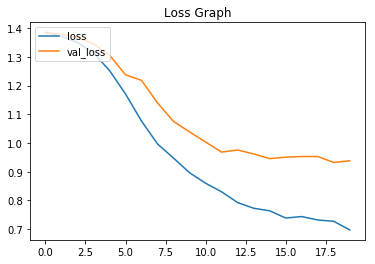

In [13]:
plt.plot(train_history.history["loss"])
plt.plot(train_history.history["val_loss"])
plt.title("Loss Graph")
plt.legend(['loss', 'val_loss'], loc="upper left")

In [14]:
from sklearn.metrics import confusion_matrix,  accuracy_score
pre = model.predict_classes(x_test)
print("acc:", round(accuracy_score(y_test, pre)*100,2),"%")

pd.DataFrame(confusion_matrix(y_test, pre))


acc: 56.77 %


,0,1,2,3
0,45,8,2,0
1,12,26,24,6
2,4,13,27,23
3,0,14,9,53


In [15]:
# y_pre = model.predict_classes(x)
# y_m = []
# trans_c_m =[]
# for q in range(1,13):
#     trans_c_m.append(round((q*0.1-0.6),4))
# #     print(q,trans_c_m[q])
        
# for i in range(len(y_pre)):
#     y_m.append(trans_c_m[y_pre[i]])
# y_real = y_raw

In [16]:
# df = pd.DataFrame()
# df["y_pre"] = y_m
# df["y_real"] = y_real
# # df.to_csv("bt_0515.csv")
# df.describe()

In [17]:
l = np.array([1,2,3])
l.max()

3